In [1]:
import numpy as np
import scanpy.api as sc
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
from matplotlib import colors as col
from gini import gini

import warnings
from rpy2.rinterface import RRuntimeWarning

%load_ext rpy2.ipython

/app/python37/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)


plt.rcParams['figure.figsize']=(5,5) #rescale figures
#sc.pl.reset_rcParams() #reset figure parameters
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.5 umap==0.3.10 numpy==1.20.0 scipy==1.6.0 pandas==1.2.1 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.6.1 leidenalg==0.7.0


In [3]:
# Data files
data_dir = './data/Ketamine_Single_Cell/Count_Matrices/'
data_file_end = '_RAW_NumReads.tsv'
data_chip1 = 'C92579'
data_chip2 = 'C93361'
data_chip3 = 'C93374'
data_chip4 = 'C93391'
data_chip5 = 'C93396'
data_chip6 = 'C93411'

adata_file = './data/Ketamine_Single_Cell/Ketamine_full_pp_scran_nb_final.h5ad'
adata_hvg_file = './data/Ketamine_Single_Cell/Ketamine_full_pp_scran_nb_hvg_final.h5ad'
count_data_file = './data/Ketamine_Single_Cell/Ketamine_full_counts_qc1750_prescran_nb_final.h5ad'
count_noqc_data_file = './data/Ketamine_Single_Cell/Ketamine_full_counts_noqc_prescran_nb_final.h5ad'

In [4]:
# Load expression data
data = pd.read_table(data_dir+data_chip1+data_file_end)
data = data.join(pd.read_table(data_dir+data_chip2+data_file_end))
data = data.join(pd.read_table(data_dir+data_chip3+data_file_end))
data = data.join(pd.read_table(data_dir+data_chip4+data_file_end))
data = data.join(pd.read_table(data_dir+data_chip5+data_file_end))
data = data.join(pd.read_table(data_dir+data_chip6+data_file_end))

In [5]:
#Load metadata
meta_dir = './data/Ketamine_Single_Cell/Meta/'
meta_file_end = '_Manually_Cleaned_WellList.TXT'
meta_chip1 = 'iCELL8_files/'+data_chip1[1:]+"_KET008"
meta_chip2 = 'iCELL8_files/'+data_chip2[1:]+"_KET006"
meta_chip3 = 'iCELL8_files/'+data_chip3[1:]+"_KET004"
meta_chip4 = 'iCELL8_files/'+data_chip4[1:]+"_KET003"
meta_chip5 = 'iCELL8_files/'+data_chip5[1:]+"_KET001"
meta_chip6 = 'iCELL8_files/'+data_chip6[1:]+"_KET007"

meta_data = pd.read_table(meta_dir+meta_chip1+meta_file_end)
meta_data['chip'] = [data_chip1]*np.size(meta_data,0)

tmp = pd.read_table(meta_dir+meta_chip2+meta_file_end)
tmp['chip'] = [data_chip2]*np.size(tmp,0)
meta_data = meta_data.append(tmp, ignore_index=True)

tmp = pd.read_table(meta_dir+meta_chip3+meta_file_end)
tmp['chip'] = [data_chip3]*np.size(tmp,0)
meta_data = meta_data.append(tmp, ignore_index=True)

tmp = pd.read_table(meta_dir+meta_chip4+meta_file_end)
tmp['chip'] = [data_chip4]*np.size(tmp,0)
meta_data = meta_data.append(tmp, ignore_index=True)

tmp = pd.read_table(meta_dir+meta_chip5+meta_file_end)
tmp['chip'] = [data_chip5]*np.size(tmp,0)
meta_data = meta_data.append(tmp, ignore_index=True)

tmp = pd.read_table(meta_dir+meta_chip6+meta_file_end)
tmp['chip'] = [data_chip6]*np.size(tmp,0)
meta_data = meta_data.append(tmp, ignore_index=True)

del tmp

key = meta_data['chip']+'_CELL_'+meta_data['Row'].astype('str')+'_'+meta_data['Col'].astype('str')+'_'+meta_data['Sample'].str.replace(' ', '_')+'_'+meta_data['Barcode']
meta_data['key'] = key
meta_data.set_index('key', inplace=True)

In [6]:
#cnts = data.as_matrix()
cnts = data.values

In [7]:
#Create AnnData object and load in sample and variable metadata
adata = sc.AnnData(cnts.transpose())

adata.obs_names = data.columns.values
adata.obs['sample'] = [s.split("_")[4] for s in adata.obs_names]
adata.obs['chip'] = [s.split("_")[0] for s in adata.obs_names]
adata.obs['condition'] = [s[0:2] in ["2Y", "8Y", "4R", "9G"] for s in adata.obs['sample']]
adata.obs['chip_pair'] = [s.split("_")[4][0] for s in adata.obs_names]

#Add loaded meta data to AnnData object
tmp = pd.DataFrame(adata.obs_names)
tmp = tmp.join(meta_data, on=tmp.columns.values[0])

adata.obs['candidate'] = tmp['Candidate'].tolist()
adata.obs['microscopy_state'] = tmp['State'].tolist()
adata.obs['quality_signal'] = tmp['Signal1'].tolist()
adata.obs['quality_signal'].fillna(0, inplace=True)
adata.obs['damage_signal'] = tmp['Signal2'].tolist()
adata.obs['damage_signal'].fillna(0, inplace=True)

#Testing
print(adata.obs['damage_signal'][:5])

#Add Ensembl IDs
adata.var_names = list(data.index)

#Testing
pd.crosstab(adata.obs['microscopy_state'], adata.obs['candidate'])

C92579_CELL_0_10_8Yellow_AACCTTCGACT    0.0
C92579_CELL_0_14_8Blue_AACCAATCTCT      0.0
C92579_CELL_0_16_8Blue_AACCAACTAGA      0.0
C92579_CELL_0_17_8Blue_AACCAAGATTC      0.0
C92579_CELL_0_19_8Blue_AACCAATATAG      0.0
Name: damage_signal, dtype: float64


candidate,False,True
microscopy_state,,
Good,0,5132
"Inconclusive, ManualUse",1,0
"Inconclusive, ManualUse, LowConfidence",1,0
"ManualUse, CellsInControl",47,0
"ManualUse, Cluster",30,0
"ManualUse, Cluster, LowConfidence",10,0
"ManualUse, HasDeadCells",43,0
"ManualUse, HasDeadCells, Cluster",1,0
"ManualUse, HasDeadCells, Cluster, LowConfidence",3,0


### Correct the 'Pos' label and associated 'condition' label

In [8]:
adata.obs['sample'].value_counts()

8Blue      1499
8Yellow    1241
4Green      681
9Green      678
4Red        642
9Blue       435
2Yellow     245
2Green      226
Pos          48
Neg          30
Name: sample, dtype: int64

In [9]:
adata.obs['chip'][adata.obs['sample'] == 'Pos'].value_counts()

C92579    13
C93391     9
C93374     7
C93361     7
C93396     7
C93411     5
Name: chip, dtype: int64

In [10]:
adata.obs['sample'][(adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C92579')]
ids = np.flatnonzero((adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C92579'))
adata.obs['sample'][ids] = pd.Series(['8Yellow' for i in range(len(ids))])

/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
adata.obs['sample'][(adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93396')]
ids = np.flatnonzero((adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93396'))
adata.obs['sample'][ids] = pd.Series(['2Yellow' for i in range(len(ids))])

/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
adata.obs['sample'][(adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93391')]
ids = np.flatnonzero((adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93391'))
adata.obs['sample'][ids] = pd.Series(['4Red' for i in range(len(ids))])

/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
adata.obs['sample'][(adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93374')]
ids = np.flatnonzero((adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93374'))
adata.obs['sample'][ids] = pd.Series(['4Green' for i in range(len(ids))])

/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
adata.obs['sample'][(adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93361')]
ids = np.flatnonzero((adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93361'))
adata.obs['sample'][ids] = pd.Series(['9Blue' for i in range(len(ids))])

/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
adata.obs['sample'][(adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93411')]
ids = np.flatnonzero((adata.obs['sample'] == 'Pos') & (adata.obs['chip'] == 'C93411'))
adata.obs['sample'][ids] = pd.Series(['8Blue' for i in range(len(ids))])

/app/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
adata.obs['sample'].value_counts()

8Blue      1504
8Yellow    1254
4Green      688
9Green      678
4Red        651
9Blue       442
2Yellow     252
2Green      226
Neg          30
Name: sample, dtype: int64

In [17]:
#Add gene names
gene_symbols = pd.read_table('./data/Ketamine_Single_Cell/ensembl_mgi_symbol_mapping_biomart.txt')

#Prune duplicate ENSG mappings
gene_symbols = gene_symbols.drop_duplicates(gene_symbols.columns.values[0])

ensg = pd.DataFrame(adata.var_names)
ensg.columns = [gene_symbols.columns.values[0]]
mapping = ensg.join(gene_symbols.set_index(gene_symbols.columns.values[0]), on=ensg.columns.values[0])

#Ensure all NaN values are replaced by strings
mapping = mapping.fillna("-")
adata.var['gene_symbols'] = mapping[mapping.columns.values[1]].tolist()

del ensg

... storing 'sample' as categorical
... storing 'chip' as categorical
... storing 'chip_pair' as categorical
... storing 'microscopy_state' as categorical
... storing 'gene_symbols' as categorical


/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


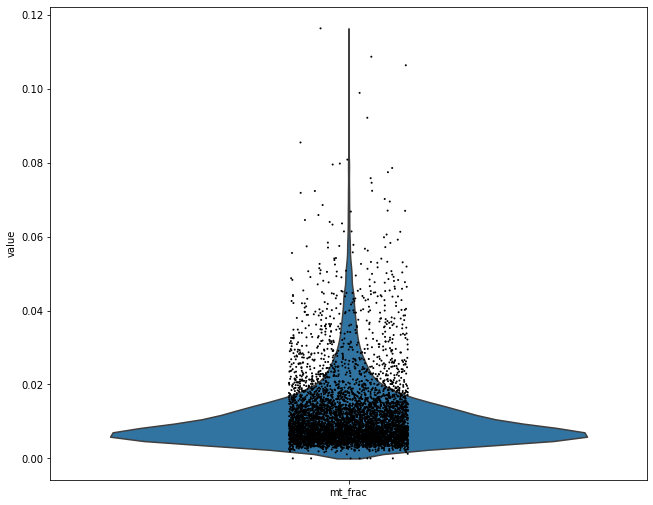

/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


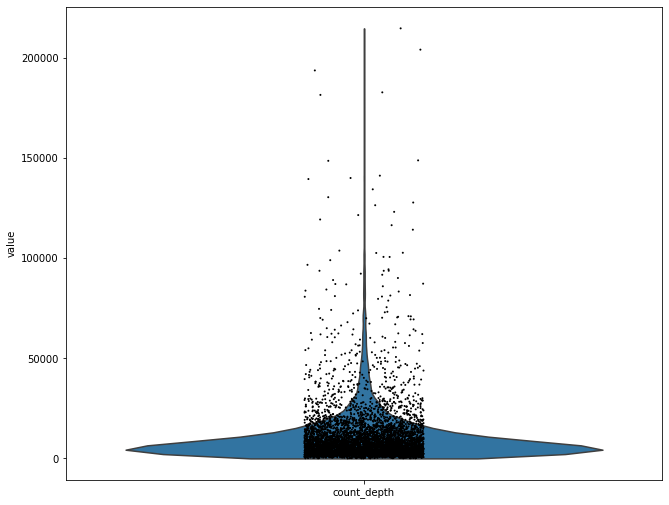

/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/app/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


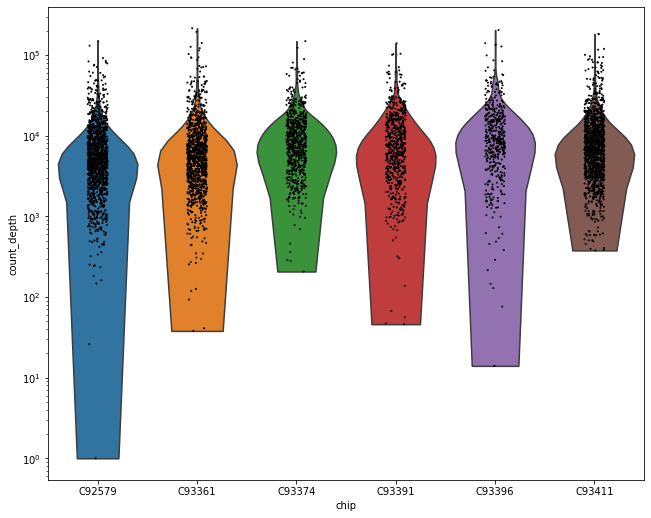

<class 'NoneType'>


In [18]:
#Compute possible confounding factors
adata.obs['count_depth'] = np.sum(adata.X, 1)
adata.obs['n_genes'] = np.sum(adata.X>0,1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var['gene_symbols']]
adata.obs['mt_frac'] = np.sum(adata.X[:,mt_gene_mask], 1)/adata.obs['count_depth']

#Plot the factors:
plt.rcParams['figure.figsize']=(9,9) #rescale figures
p1 = sc.pl.violin(adata, 'mt_frac', group_by='chip', size=2, save='_mt_frac')
p2 = sc.pl.violin(adata, 'count_depth', group_by='chip', size=2, save='_umipc')

#p3 = sc.pl.violin(adata[adata.obs['count_depth']<20000,:], 'count_depth', group_by='chip', size=2, save='_umipc_zoom_u10000')
p3 = sc.pl.violin(adata, 'count_depth', groupby='chip', size=2, log=True, cut=0, save='ketamine_full_count_depth_per_chip_log_final') #
#p3.set_yscale('log')
#p3.set_ylim(-50000,50000)
#plt.show()
#p3.savefig('./figures/ketamine_full_count_depth_per_chip_log.png')
print(type(p3))
plt.rcParams['figure.figsize']=(5,5) #rescale figures

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


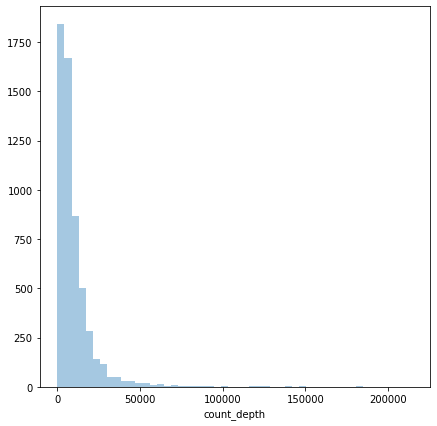

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


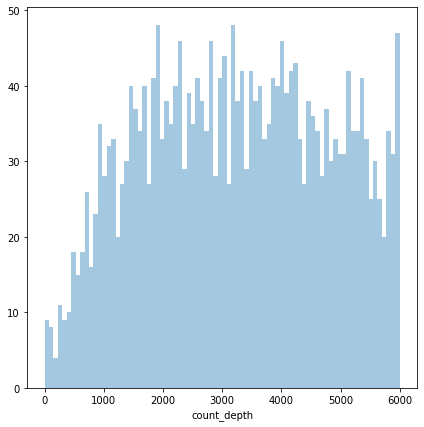

/app/python37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


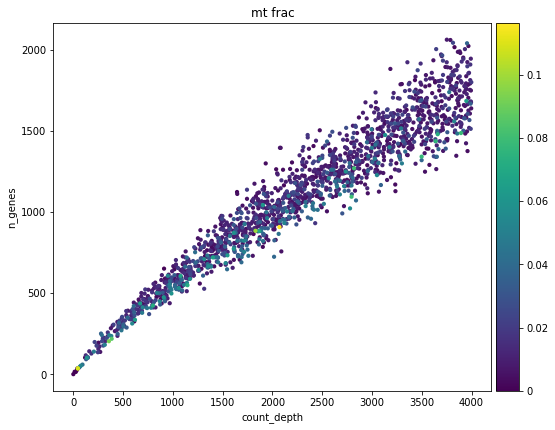

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


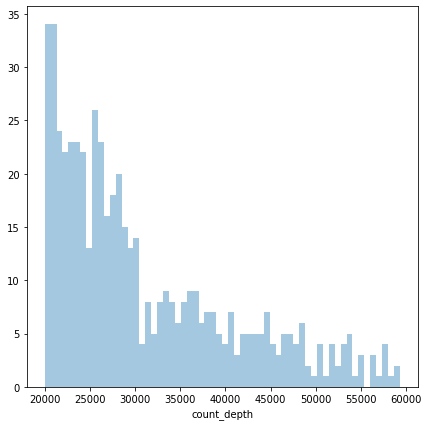

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


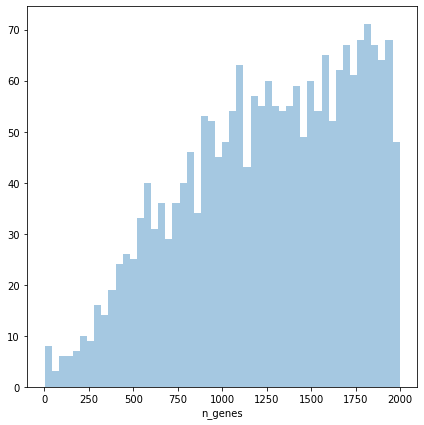

In [19]:
#Plot some QC metrics:
rcParams['figure.figsize']=(7,7) #rescale figures
p1 = sb.distplot(adata.obs['count_depth'], kde=False)
fig = p1.get_figure()
fig.savefig('./figures/ketamine_full_count_depth_final.png')
plt.show()

p2 = sb.distplot(adata.obs['count_depth'][adata.obs['count_depth']<6000], kde=False, bins=80)
fig = p2.get_figure()
fig.savefig('./figures/ketamine_full_count_depth_lowCounts_final.png')
plt.show()

p3 = sc.pl.scatter(adata[adata.obs['count_depth']<4000,:], 'count_depth', 'n_genes', color='mt_frac', save='_counts_genes_mtfrac_lowCounts_final')

p4 = sb.distplot(adata.obs['count_depth'][adata.obs['count_depth']>20000][adata.obs['count_depth']<60000], kde=False, bins=60)
fig = p4.get_figure()
fig.savefig("./figures/ketamine_full_count_depth_highCounts_final.png")
plt.show()

p5 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=50)
fig = p5.get_figure()
fig.savefig('./figures/ketamine_full_gene_number_lowGenes_final.png')
plt.show()
rcParams['figure.figsize']=(5,5) #rescale figures


## Filtering decisions

It looks as though there may be a population of cells at 30-42k counts... this might however be a double population. As there are about 75 cells there, this is more than 1% of total cells, and with microscopy validation we should have a low double detection rate. So counts will be filtered out from 42k.

On the low count side, there is no significant MT signal. Based on count distributions there may be a peak at 800-1200 counts, which should probably be filtered out as this is in the low count range and may include apoptotic cells. To ensure data quality, the next minor peak is also filtered. This gives a count threshold of 1750.

The distribution shows that there is a low gene peak which can be filtered out with a threshold of approximately 700.

In [20]:
adata.write(count_noqc_data_file)

In [21]:
#Filter cells for harsh qc data: 
print('Total number of cells: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['microscopy_state'] != 'NoCells']
print('Number of cells after microscopy state filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1750)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 42000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))


#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 10 cells so that differential expression could be done on 5 vs 5
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

# Zero variance
#very_high_disp_filter = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, min_disp=0.5)
#print('Number of genes after high dispersion filter: {:d}'.format(adata[:,very_high_disp_filter['gene_subset']].n_vars))
#adata.var['highly_variable_genes'] = very_high_disp_filter['gene_subset']
#adata.var['expression_mean'] = very_high_disp_filter['means']
#adata.var['dispersion'] = very_high_disp_filter['dispersions']
#adata.uns['highly_variable_gene_results'] = very_high_disp_filter

#adata = adata[:,high_disp_filter['gene_subset']]

Total number of cells: 5725
Number of cells after microscopy state filter: 5694


/app/python37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 505 cells that have less than 1750 counts


Trying to set attribute `.obs` of view, copying.


Number of cells after min count filter: 5189
filtered out 176 cells that have more than 42000 counts
Number of cells after max count filter: 5013
Number of cells after MT filter: 5013


/app/python37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 5013
Total number of genes: 34482
filtered out 13812 genes that are detected in less than 20 cells
Number of genes after cell filter: 20670


In [22]:
adata.var['dropout'] = np.mean(adata.X==0,0)
adata.var['mean_expr'] = np.mean(adata.X,0)
adata.var['log10_mean_expr'] = np.log10(np.mean(adata.X,0))
adata.var['gini_index'] = np.apply_along_axis(gini, 0, adata.X)

In [23]:
#Recompute after filtering
adata.obs['count_depth'] = np.sum(adata.X, 1)
adata.obs['n_genes'] = np.sum(adata.X>0,1)

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


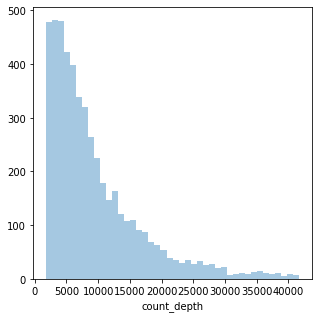

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


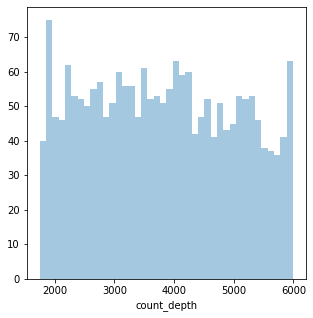

/app/python37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


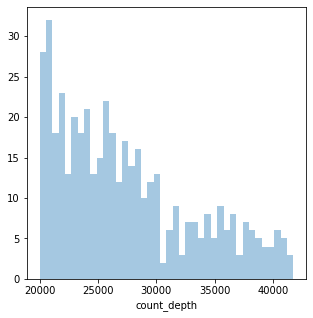

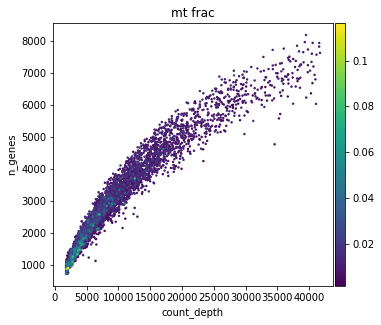

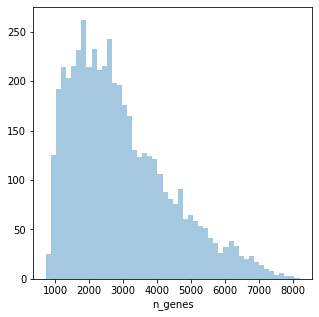

In [24]:
#Look at QC metrics after filtering
#rcParams['figure.figsize']=(7,7) #rescale figures
sb.distplot(adata.obs['count_depth'], kde=False)
plt.show()

sb.distplot(adata.obs['count_depth'][adata.obs['count_depth']<6000], kde=False, bins=40)
plt.show()

sb.distplot(adata.obs['count_depth'][adata.obs['count_depth']>20000], kde=False, bins=40)
plt.show()

#sc.pl.scatter(adata[adata.obs['count_depth']<4000,:], 'count_depth', 'n_genes', color='mt_frac')
sc.pl.scatter(adata, 'count_depth', 'n_genes', color='mt_frac')


#sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=50)
sb.distplot(adata.obs['n_genes'], kde=False, bins=50)
plt.show()
#rcParams['figure.figsize']=(5,5) #rescale figures


QC graphs look good for this data set

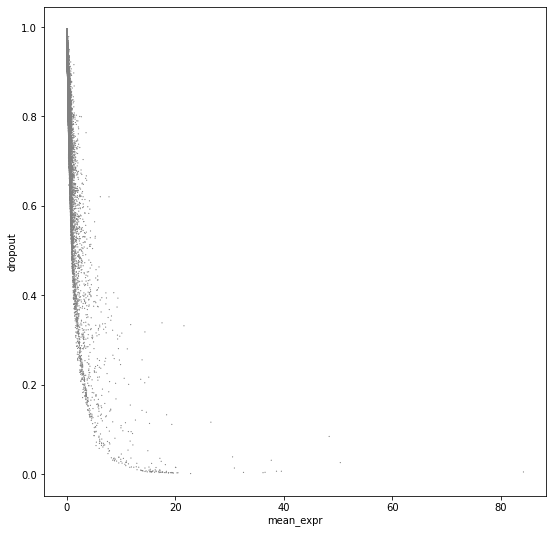

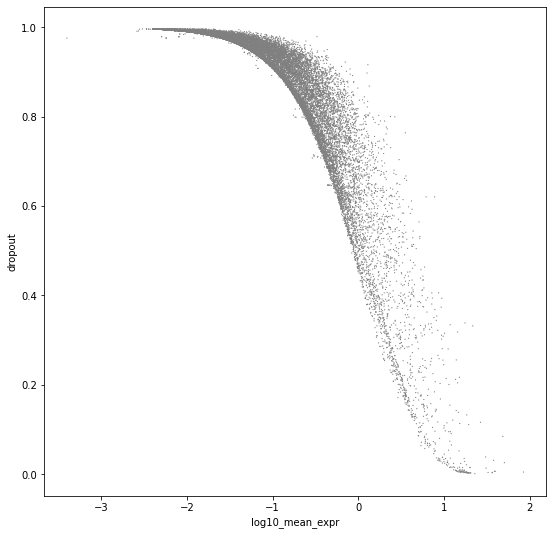

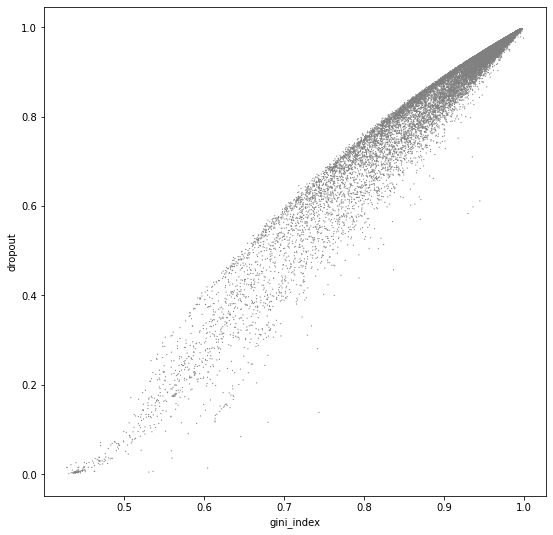

In [25]:
sc.pl.scatter(adata, 'mean_expr', 'dropout', ax=plt.figure(figsize=(9,9)).gca())
sc.pl.scatter(adata, 'log10_mean_expr', 'dropout', ax=plt.figure(figsize=(9,9)).gca())
sc.pl.scatter(adata, 'gini_index', 'dropout', ax=plt.figure(figsize=(9,9)).gca())

## Potentially ambient genes

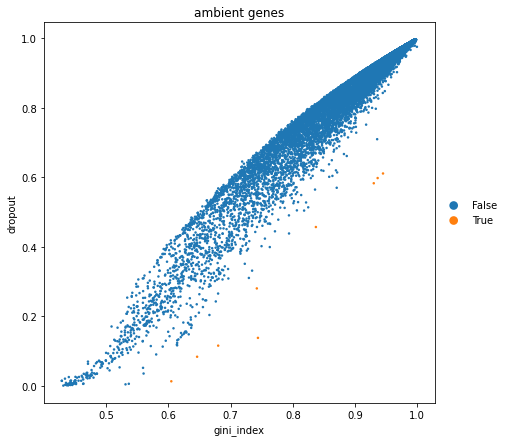

In [26]:
#Identify potential ambient genes by dropout and gini index fitting
lm, cov = np.polyfit(adata.var['gini_index'], adata.var['dropout'], deg=1, cov=True)
fit = np.polyval(lm, adata.var['gini_index'])

sd_dropout = np.std(adata.var['dropout'])
adata.var['ambient_genes'] = [adata.var['dropout'] < (fit-1.5*sd_dropout)][0]
adata.var["ambient_genes"] = adata.var["ambient_genes"].astype("category")

ax = sc.pl.scatter(adata, 'gini_index', 'dropout', color='ambient_genes', ax=plt.figure(figsize=(7,7)).gca(), size=25, show=True)
# ax.plot(adata.var['gini_index'], fit, label='fit')
# plt.show()

In [27]:
adata.var['gene_symbols'][adata.var['ambient_genes'] == True]

ENSMUSG00000002985.16      Apoe
ENSMUSG00000052305.6     Hbb-bs
ENSMUSG00000032554.15       Trf
ENSMUSG00000015090.13     Ptgds
ENSMUSG00000069917.7     Hba-a2
ENSMUSG00000053477.16      Tcf4
ENSMUSG00000027447.6       Cst3
ENSMUSG00000031425.15      Plp1
ENSMUSG00000069919.7     Hba-a1
Name: gene_symbols, dtype: category
Categories (19259, object): ['0610009B22Rik', '0610009O20Rik', '0610010F05Rik', '0610010K14Rik', ..., 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']

In [28]:
np.sum(adata.var['ambient_genes'] == True)

9

In [29]:
#Check dropout
np.sum(adata.X > 0)/np.size(adata.X)

0.14151426899640035

## Normalization (scran and negbin)

In [30]:
#Keep a copy of raw data counts after filtering (for downstream DE testing)
adata_counts = adata.copy()

In [31]:
#Testing
print(adata_counts.X[0,229])
print(adata_counts.X[0,230])
print(adata_counts.X[0,2095])

0.5
0.5
0.000101021


Note that counts include splitting of reads that are mappable to multiple locations. This should not be a problem for the NB model fit, as it's interpolated to work with continuous data.

In [32]:
adata_counts.write(count_data_file)

In [33]:
#Perform a clustering for improved scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=50)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups')

normalizing by total count per cell


/app/python37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [34]:
#Prep data for scran run
input_groups = adata_pp.obs['groups']
data_mat = np.array(adata.X.T)

In [35]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)

size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC

In [36]:
adata.obs['size_factors'] = size_factors

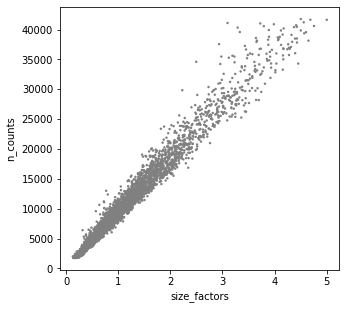

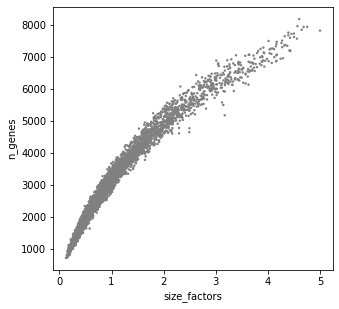

In [37]:
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

In [38]:
#Keep raw data with scran normalization
adata.X = np.divide(adata.X.T, adata.obs['size_factors'].tolist()).T
sc.pp.log1p(adata)
adata.raw = adata

In [39]:
adata.raw.var

,gene_symbols,n_cells,dropout,mean_expr,log10_mean_expr,gini_index,ambient_genes
ENSMUSG00000090750.1,Gm21999,20,0.996010,0.004189,-2.377878,0.996167,False
ENSMUSG00000067203.7,H2-K2,93,0.981448,0.019948,-1.700098,0.982668,False
ENSMUSG00000111741.1,Gm18903,36,0.992819,0.007181,-2.143795,0.992805,False
ENSMUSG00000104240.1,Gm36858,68,0.986435,0.013764,-1.861249,0.986622,False
ENSMUSG00000085867.1,Gm5834,27,0.994614,0.005785,-2.237700,0.994941,False
...,...,...,...,...,...,...,...
ENSMUSG00000084239.1,Gm14463,32,0.993617,0.006383,-2.194948,0.993601,False
ENSMUSG00000024968.13,Rcor2,28,0.994415,0.006982,-2.156030,0.995238,False
ENSMUSG00000021807.5,-,806,0.839218,0.188111,-0.725586,0.859741,False
ENSMUSG00000074506.4,Gm10705,534,0.893477,0.116649,-0.933117,0.906220,False


In [40]:
#Check dropout
np.sum(adata.X > 0)/np.size(adata.X)

0.14151426899640035

In [41]:
#Prep data for negbin model normalization
batch_cov = adata.obs['chip']
umi_per_gene = adata.obs['count_depth']/adata.obs['n_genes']
gene_names = adata.var_names

In [50]:
%%R 
theta.reg <- function(cm, regressors, min.theta=0.01, bins=64) {
  b.id <- (1:nrow(cm)) %% max(1, bins, na.rm=TRUE) + 1
  cat(sprintf('get regularized theta estimate for %d genes and %d cells\n', nrow(cm), ncol(cm)))
  cat(sprintf('processing %d bins with ca %d genes in each\n', bins, round(nrow(cm)/bins, 0)))
  theta.estimate <- rep(NA, nrow(cm))
  for (bin in sort(unique(b.id))) {
    sel.g <- which(b.id == bin)
    bin.theta.estimate <- unlist(mclapply(sel.g, function(i) {
      as.numeric(theta.ml(cm[i, ], glm(cm[i, ] ~ ., data = regressors, family=poisson)$fitted))
    }), use.names = FALSE)
    theta.estimate[sel.g] <- bin.theta.estimate
    cat(sprintf('%d ', bin))
  }
  cat('done\n')
  raw.mean <- apply(cm, 1, mean)
  log.raw.mean <- log10(raw.mean)
  var.estimate <- raw.mean + raw.mean^2/theta.estimate
  
  fit <- loess(log10(var.estimate) ~ log.raw.mean, span=0.33)
  theta.fit <- raw.mean^2 / (10^fit$fitted - raw.mean)
  
  to.fix <- theta.fit <= min.theta | is.infinite(theta.fit)
  if (any(to.fix)) {
    cat('Fitted theta below', min.theta, 'for', sum(to.fix), 'genes, setting them to', min.theta, '\n')
    theta.fit[to.fix] <- min.theta
  }
  names(theta.fit) <- rownames(cm)
  return(theta.fit)
}

nb.residuals.glm <- function(y, regression.mat, fitted.theta, gene) {
  fit <- 0
  try(fit <- glm(y ~ ., data = regression.mat, family=negative.binomial(theta=fitted.theta)), silent=TRUE)
  if (class(fit)[1] == 'numeric') {
    message(sprintf('glm and family=negative.binomial(theta=%f) failed for gene %s; falling back to scale(log10(y+1))', 
                    fitted.theta, gene))
    return(scale(log10(y+1))[, 1])
  }
  return(residuals(fit, type='pearson'))
}

norm.nb.reg <- function(cm, regressors, min.theta=0.01, bins=64, theta.fit=NA, pr.th=NA, save.theta.fit=c()) {
  cat('Normalizing data using regularized NB regression\n')
  cat('explanatory variables:', colnames(regressors), '\n')
  if (any(is.na(theta.fit))) {
    theta.fit <- theta.reg(cm, regressors, min.theta, bins)
    if (is.character(save.theta.fit)) {
      save(theta.fit, file=save.theta.fit)
    }
  }
  
  b.id <- (1:nrow(cm)) %% max(1, bins, na.rm=TRUE) + 1
  cat('Running NB regression\n')
  res <- matrix(NA, nrow(cm), ncol(cm), dimnames=dimnames(cm))
  for (bin in sort(unique(b.id))) {
    sel.g <- rownames(cm)[b.id == bin]
    expr.lst <- mclapply(sel.g, function(gene) nb.residuals.glm(cm[gene, ], regressors, theta.fit[gene], gene), mc.preschedule = TRUE)
    res[sel.g, ] <- do.call(rbind, expr.lst)
    cat(sprintf('%d ', bin))
  }
  cat('done\n')
  if (!any(is.na(pr.th))) {
    res[res > pr.th] <- pr.th
    res[res < -pr.th] <- -pr.th
  }
  attr(res, 'theta.fit') <- theta.fit
  return(res)
}

In [51]:
%%R -i data_mat -i size_factors -i batch_cov -i umi_per_gene -i gene_names -o data_corrected
#source('./negbin_normalization/in-lineage/R/lib.R')
#options(mc.cores = 1)

data_mat = as.matrix(data_mat)
rownames(data_mat) <- gene_names
colnames(data_mat) <- names(umi_per_gene)

batch_cov = as.factor(batch_cov)

covariate_matrix = data.frame(size.factor=size_factors, umi.per.gene=umi_per_gene, batch=batch_cov, row.names=names(batch_cov))
data_corrected <- norm.nb.reg(data_mat, covariate_matrix, pr.th = 30)

Normalizing data using regularized NB regression
explanatory variables: size.factor umi.per.gene batch 
get regularized theta estimate for 20670 genes and 5013 cells
processing 64 bins with ca 323 genes in each
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 done
Fitted theta below 0.01 for 8 genes, setting them to 0.01 
Running NB regression
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 done


In [52]:
adata.X = np.transpose(data_corrected)

In [53]:
adata.raw.var

,gene_symbols,n_cells,dropout,mean_expr,log10_mean_expr,gini_index,ambient_genes
ENSMUSG00000090750.1,Gm21999,20,0.996010,0.004189,-2.377878,0.996167,False
ENSMUSG00000067203.7,H2-K2,93,0.981448,0.019948,-1.700098,0.982668,False
ENSMUSG00000111741.1,Gm18903,36,0.992819,0.007181,-2.143795,0.992805,False
ENSMUSG00000104240.1,Gm36858,68,0.986435,0.013764,-1.861249,0.986622,False
ENSMUSG00000085867.1,Gm5834,27,0.994614,0.005785,-2.237700,0.994941,False
...,...,...,...,...,...,...,...
ENSMUSG00000084239.1,Gm14463,32,0.993617,0.006383,-2.194948,0.993601,False
ENSMUSG00000024968.13,Rcor2,28,0.994415,0.006982,-2.156030,0.995238,False
ENSMUSG00000021807.5,-,806,0.839218,0.188111,-0.725586,0.859741,False
ENSMUSG00000074506.4,Gm10705,534,0.893477,0.116649,-0.933117,0.906220,False


In [54]:
#Check dropout
np.sum(adata.X > 0)/np.size(adata.X)

0.11353978446556612

## Highly variable genes

In [55]:
disp_filter = sc.pp.filter_genes_dispersion(adata.raw.X, min_disp=0.5, min_mean=0.0125)
print('Number of highly variable genes: {:d}'.format(adata[:,disp_filter['gene_subset']].n_vars))
adata.var['highly_variable_genes'] = disp_filter['gene_subset']
adata.var['expression_mean'] = disp_filter['means']
adata.var['dispersion'] = disp_filter['dispersions']

extracting highly variable genes
    finished (0:00:01)
Number of highly variable genes: 5298


/app/python37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Note:
- If using the seurat flavour, should check that the parameter log=True is passed so that log-transforming does not happen again before HVG calculation.
- neg. bin. normalized data cannot be used with this method of finding HVGs. As genes are scaled to have an expected 0 mean, the binning no longer makes sense

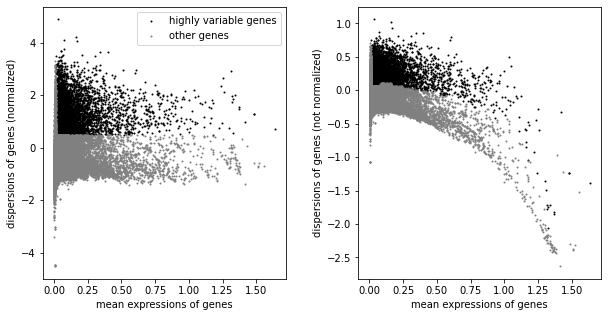

In [56]:
sc.pl.filter_genes_dispersion(disp_filter)

In [57]:
# Create a data set with only the highly variable genes
adata_hvg = adata.copy()
adata_hvg.raw = adata #Keep full negbin set in .raw
adata_hvg = adata_hvg[:,disp_filter['gene_subset']]

In [58]:
adata_hvg.raw.var['highly_variable_genes'].dtype

dtype('bool')

In [59]:
adata_hvg.raw.var

,gene_symbols,n_cells,dropout,mean_expr,log10_mean_expr,gini_index,ambient_genes,highly_variable_genes,expression_mean,dispersion
ENSMUSG00000090750.1,Gm21999,20,0.996010,0.004189,-2.377878,0.996167,False,False,0.002473,-0.175501
ENSMUSG00000067203.7,H2-K2,93,0.981448,0.019948,-1.700098,0.982668,False,False,0.013288,-0.161330
ENSMUSG00000111741.1,Gm18903,36,0.992819,0.007181,-2.143795,0.992805,False,False,0.004208,-0.283268
ENSMUSG00000104240.1,Gm36858,68,0.986435,0.013764,-1.861249,0.986622,False,False,0.006987,-0.451706
ENSMUSG00000085867.1,Gm5834,27,0.994614,0.005785,-2.237700,0.994941,False,False,0.004116,-0.087849
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000084239.1,Gm14463,32,0.993617,0.006383,-2.194948,0.993601,False,False,0.003541,-0.363058
ENSMUSG00000024968.13,Rcor2,28,0.994415,0.006982,-2.156030,0.995238,False,False,0.004510,0.054356
ENSMUSG00000021807.5,-,806,0.839218,0.188111,-0.725586,0.859741,False,False,0.110613,-0.242518
ENSMUSG00000074506.4,Gm10705,534,0.893477,0.116649,-0.933117,0.906220,False,False,0.071575,-0.224407


In [60]:
#Store file after normalization setup & HVG calculation
adata.write(adata_file)

In [61]:
adata_hvg.write(adata_hvg_file)